# Supervised Registration for LASTEN
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Import statements
Following packages are necessary:

In [1]:
import sys
import random
import os
import imageio
import json
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from endolas  import closs
from endolas import ccall
from endolas import LASTENSequence
from endolas import utils
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from endolas import UNet
from endolas import preprocess_input as pre_une
from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0


IndexError: list index out of range

# Seeding
Seeds are set to ensure reproducible training.

In [3]:
tf.keras.backend.clear_session()

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Data
Import training images

In [6]:
path_train = r'../data/LASTEN/train'
path_validation = r'../data/LASTEN/validation'
path_fixed = r'../data/LASTEN/fix'

width = 384
height = 384

grid_width = 18
grid_height = 18

batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [7]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 384, 384, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Training Preparation
Prepare the settings for training the model.

In [12]:
save_path =  r'results'

logger = CSVLogger(save_path + "/log")
timelogger = ccall.TimeHistory(save_path)
checker = ModelCheckpoint(save_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(save_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='med')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [13]:
model.fit(train_gen,
          epochs=2,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1)

Epoch 1/2


c:\users\julian\anaconda3\envs\endolas\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


40/40 [==============================] - 271s 7s/step - loss: 1458.3691 - med: 32.5780 - val_loss: 1989.5452 - val_med: 40.2732
Epoch 2/2
40/40 [==============================] - 287s 7s/step - loss: 581.9662 - med: 20.1213 - val_loss: 1543.8694 - val_med: 34.2941


# Evaluation
Quick overview if the proposed displacements are reasonable.

In [14]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val 

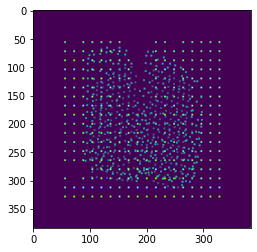

In [15]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

#plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
#plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

#u_x.dump(store_path + "/u_x")
#u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
#plt.imsave(store_path + "/warp.png", warp)